# Character Recognition using CNN (Part 1 of Task 2)

> Image Classification using convolution neural networks. Author: [Pratik Kumar](https://pr2tik1.github.io)

Objective :  

> Use this [dataset](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip) to train a
CNN. Use no other data source or pretrained networks, and explain your design choices during preprocessing, model building and training. Also, cite the sources you used to
borrow techniques. A test set will be provided later to judge the performance of your
classifier. Please save your model checkpoints.


## 1. Importing Modules

To develop and train a convolution neural network architecture, I have used PyTorch framework. Along with this OpenCV, numpy, pandas and matplotlib for image data handling and plotting are used. In this section we will importing all necessary modules.  

In [5]:
import random
import copy
import time 
import pandas as pd 
from PIL import Image
from torchsummary import summary


import torch
import torchvision
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [8]:
from data import dataset
from plotting import plot_curve, plot_images
from model import Net
from train import train_model, compute_accuracy, cal_accuracy

## 2. Data Preprocessing

The initial step is to create a dataframe of labels generated by carefully examining the dataset provided. This Labels.csv is mapped to image with its corresponding labels. This is necessary step for our model to understand classes. PyTorch also provides torchvision.data.ImageFolder() function to   

To change images into vector with normalisation and augmentation, following values are fetched to torchvision.transforms function. We perform: 
    
    - Random Rotations
    - Random Resizing and Cropping 
    - Change Image arrays to Tensor
    - Normalize

In [9]:
train_transforms = transforms.Compose([
                   transforms.RandomRotation(degrees=45),
                   transforms.RandomResizedCrop(64, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
                   transforms.ToTensor(),
                   transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])

               ])

Loading custom dataset that returns images and labels. 

In [10]:
LABELS='data/labels.csv' 
ROOT = 'data/train'

train_data = dataset(csv=LABELS, img_path=ROOT, transform = train_transforms)

In [11]:
df=pd.read_csv('data/labels.csv' )
df.head()

,filenames,labels_code,labels
0,img001-001.png,img001,0
1,img001-002.png,img001,0
2,img001-003.png,img001,0
3,img001-004.png,img001,0
4,img001-007.png,img001,0


Splitting the dataset into training and validation dataset. This is needed to keep track of how our model performs.

In [12]:
VALID_RATIO = 0.83
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data,[n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = train_transforms

The final number of training and validation dataset.

In [13]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 2058
Number of validation examples: 422


Further we take our tensor datasets and put fetch them into Dataloader with certain batches(BATCH_SIZE). 

In [14]:
BATCH_SIZE = 256
train_iterator = data.DataLoader(train_data,batch_size = BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data,batch_size = BATCH_SIZE)

## 3. Images
Following are the images after preprocessing steps. The images are of (1200 x 900)px initially, but are processed to (64 x 64)px size and Rotated to 45 degrees. Since the images are png images they have 3 channels.

In [15]:
img_pil = Image.open('data/train/img001-001.png')
print('Image Channels and Size: ', img_pil.mode, img_pil.size)

Image Channels and Size:  RGB (1200, 900)


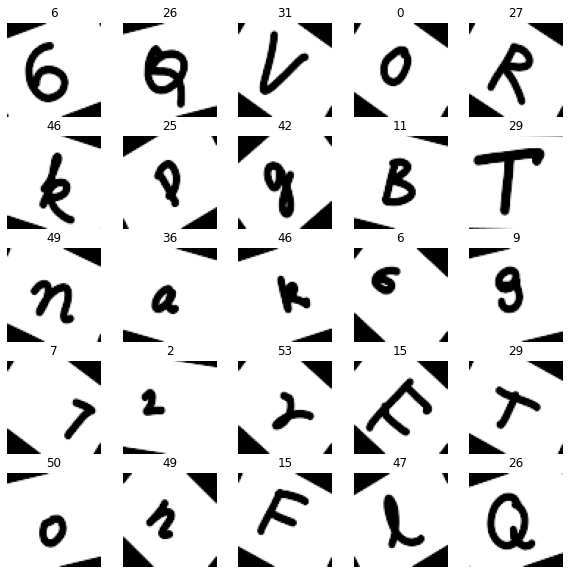

In [16]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])
classes = list(df['labels'].unique())
plot_images(images, labels, classes)

## 4. Hyper-parameters and model development

In this section setting device to cuda or cpu based upon availablity. Loading the model and setting hyper parameters for training. I have used Cross Entropy loss function which is suitable for multi-class classification tasks. The classes in our task is 10+26+26=62 classes, as we have digits, small letters and capital letters. The updation rule is Adam optimizer with learning rate of 1e-4.

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(62)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device

device(type='cuda')

Our model is inspired by AlexNet which was among the early CNNs that performed well in ImageNet Classification Challenge. This has 8 layers: 5 Convolution Layers and 3 Fully Connected Layers. The input to intital convolution layer is 64x64x3 image that are processed into arrays with values ranging from 0 to 1. Final output layer after series of convolution, pooling, and drop outs, yield predictions for the 62 classes.  

In [18]:
model

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

Following is summary of model. One can notice the size of the model and number of parameters.

In [19]:
summary(model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

## 5. Training the custom model Net()

Training the model on the character images dataset. This block trains the model and saves it as 'model.pt' in same directory. The train_model function returns lists of training and validation accuracies and as well as the losses. The total epochs are set to 60, taking care of underfitting and overfitting.  

In [20]:
train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = train_model(model=model, #model from scratch 
                                             num_epochs=50,
                                             train_iterator=train_iterator,
                                             valid_iterator=valid_iterator, 
                                             optimizer=optimizer,
                                             criterion=criterion, 
                                             device=device,
                                             model_save =True,
                                             model_name='model.pt')

Epoch: 1 	Training Loss: 0.018052 	Validation Loss: 0.019575
Validation loss decreased (inf --> 0.019575).  Saving model ...
Epoch: 2 	Training Loss: 0.018006 	Validation Loss: 0.019635
Epoch: 3 	Training Loss: 0.017971 	Validation Loss: 0.019677
Epoch: 4 	Training Loss: 0.017909 	Validation Loss: 0.019628
Epoch: 5 	Training Loss: 0.017860 	Validation Loss: 0.019396
Validation loss decreased (0.019575 --> 0.019396).  Saving model ...
Epoch: 6 	Training Loss: 0.017694 	Validation Loss: 0.019107
Validation loss decreased (0.019396 --> 0.019107).  Saving model ...
Epoch: 7 	Training Loss: 0.017471 	Validation Loss: 0.018895
Validation loss decreased (0.019107 --> 0.018895).  Saving model ...
Epoch: 8 	Training Loss: 0.017442 	Validation Loss: 0.018849
Validation loss decreased (0.018895 --> 0.018849).  Saving model ...
Epoch: 9 	Training Loss: 0.017302 	Validation Loss: 0.018839
Validation loss decreased (0.018849 --> 0.018839).  Saving model ...
Epoch: 10 	Training Loss: 0.016993 	Valida

## 6. Plotting Loss and Accuracy of model

The lists from the above train_model function are visualized below.

### 6.1. Loss Curve

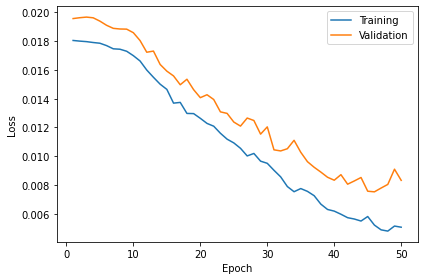

In [21]:
plot_curve(train_loss_list, valid_loss_list)

### 6.2. Accuracy Curve

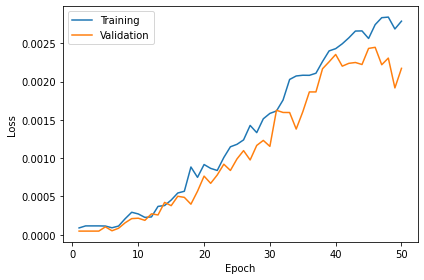

In [22]:
plot_curve(train_acc_list, valid_acc_list)

## 7. Calculate accuracy

The training and validation accuracy is calculated in this block to keep track of how oue model performs.

In [23]:
#Training Accuracy
cal_accuracy(train_iterator, model, device)

Got 1195 / 2058 with accuracy 58.07
Training:  None


In [24]:
#Validation Accuracy
cal_accuracy(valid_iterator, model, device)

Got 189 / 422 with accuracy 44.79
Validation:  None


## Conclusion

The model performs well but has less accuracy of about 50-60%. This can be increased using augmentations and better hyperparameters.  

# Thank you!

Author : Pratik Kumar
- References: 

    - [AlexNet Paper](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
    - [MNIST](http://yann.lecun.com/exdb/mnist/)
    - [PyTorch Tutorials](https://pytorch.org/tutorials/)